In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [2]:
img_l = np.asanyarray(Image.open("hangerL-small.png").convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("hangerR-small.png").convert("RGB")).astype(np.int)

In [3]:
img_l = img_l[20:-20, 50:-50]
img_r = img_r[20:-20, 50:-50]

In [4]:
img_l.shape

(140, 220, 3)

In [5]:
img_r.shape

(140, 220, 3)

## Loss functions definition

In [6]:
def g_loss_l1(a, b, par=0):
    return abs(a) + abs(b)

def g_loss_l2(a, b, par=0):
    return sqrt(abs(a)**2 + abs(b)**2)

def g_loss_min_l1(a, b, par):
    return min(par, abs(a) + abs(b))

def g_loss_min_l2(a, b, par):
    return min(par, sqrt(abs(a)**2 + abs(b)**2))

In [7]:
def f_loss_l1(a):
    return np.sum(np.abs(a), axis=-1)

def f_loss_l2(a):
    return np.sqrt(np.sum(a**2, axis=-1))

## Params definition

In [8]:
kg_max=50
kv_max=4

kv_half = kv_max//2

alpha=20
g_loss = [g_loss_l1, g_loss_l2, g_loss_min_l1, g_loss_min_l2][3]
f_loss = [f_loss_l1, f_loss_l2][1]
b = 20

## Precomputing node2node losses

In [9]:
height = img_r.shape[0]
length = img_r.shape[1]

g = np.zeros((kg_max*kv_max, kg_max*kv_max), dtype=np.float32)

for k1 in range(kg_max*kv_max):
    for k2 in range(kg_max*kv_max):
        kg1 = k1 % kg_max
        kv1 = k1 // kg_max
        kg2 = k2 % kg_max
        kv2 = k2 // kg_max
        g[k1,k2] = g_loss(kg1 - kg2,kv1 - kv2, b)
g = alpha*g

In [10]:
kg1

49

In [11]:
kv1

3

## Minimal path finding and recording

In [12]:
start = timer()
img_shift = np.ones((height, length))

for i in range(img_shift.shape[0]):
    #start = timer()
    f = np.inf*np.ones((length, kg_max*kv_max), dtype=np.float32)
    for k in range(1, kg_max*kv_max):
        kg1 = k % kg_max
        kv1 = k // kg_max - kv_half
        if i+kv1 < height and i+kv1 >= 0:
            f[:length-kg1, k] = f_loss(img_r[i,:length-kg1] - img_l[i+kv1,kg1:])

    #end = timer()
    #print('\n\nconstruct graph:',timedelta(seconds=end-start))            
    #start = timer()

    pass_to_prev = np.zeros(f.shape, dtype=np.int)
    for p in range(1, length):
        ta = f[p-1, :] + g
        ind = np.argmin(ta, axis=1)
        f[p, :] += np.min(ta, axis=1)
        pass_to_prev[p, :] = ind
    
    #end = timer()
    #print('\n\nfind path:',timedelta(seconds=end-start))
    #start = timer()
    
    line_shift = np.ones(length, dtype=np.int)
    line_shift[-1] = np.argmin(f[-1,:])
    for p in reversed(range(length-1)):
        line_shift[p] = pass_to_prev[p+1, line_shift[p+1]]
    
    img_shift[i] = line_shift
    #end = timer()
    #print('\n\nrecover path:',timedelta(seconds=end-start)) 

    print(i, end=" ")
    #print("\n"+20*"=")

end = timer()
print('\n\n\nTime per image',timedelta(seconds=end-start))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 


Time per image 0:00:05.052387


## output image transforming and shifts decoding

In [13]:
img_shift2 = np.zeros((height, length, 3), dtype=np.int)
img_shift2[:,:,0] = img_shift % kg_max # horizontal
img_shift2[:,:,1] = img_shift // kg_max - kv_half # vertical

np.save("img_shift.npy", img_shift2)

img_shift3 = img_shift2.copy()

img_shift3 = np.linalg.norm(img_shift3, axis=-1)
img_shift3 = 255*img_shift3/img_shift3.max()

#img_shift2 = 255*img_shift2/img_shift2.max()
#img_shift2[:,:,0] = 255*img_shift2[:,:,0]/img_shift2[:,:,0].max()
#img_shift2[:,:,1] = 255*img_shift2[:,:,1]/img_shift2[:,:,1].max()

In [14]:
img_shift2[:,:,0].max()

44

## Horizontal shift (normed at 255)

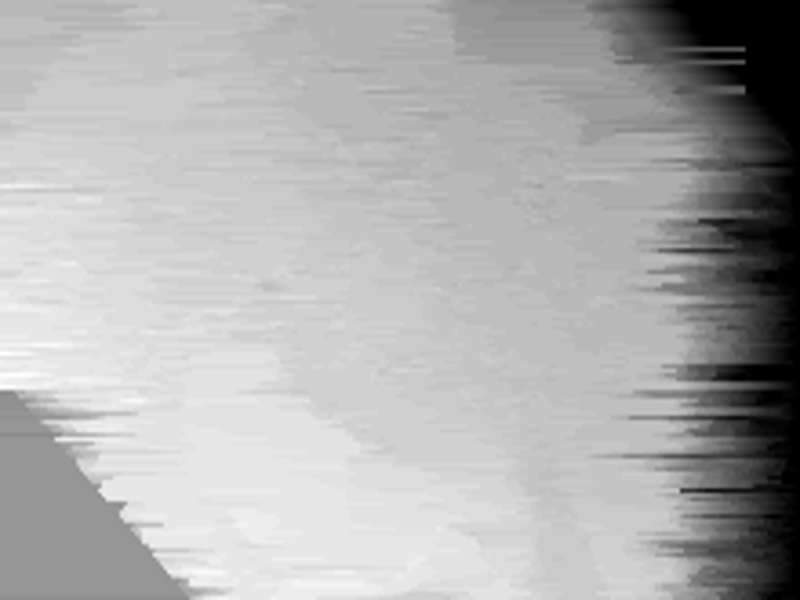

In [15]:
Image.fromarray((255*img_shift2[:,:,0]/img_shift2[:,:,0].max()).astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Vertical shift (normed at 255)

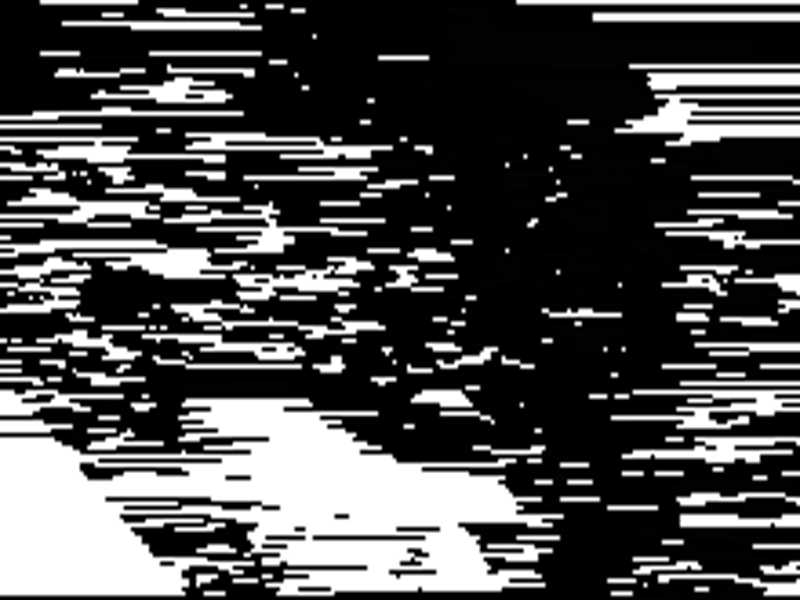

In [16]:
Image.fromarray((255*img_shift2[:,:,1]/img_shift2[:,:,1].max()).astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Color shift image (normed at 255)

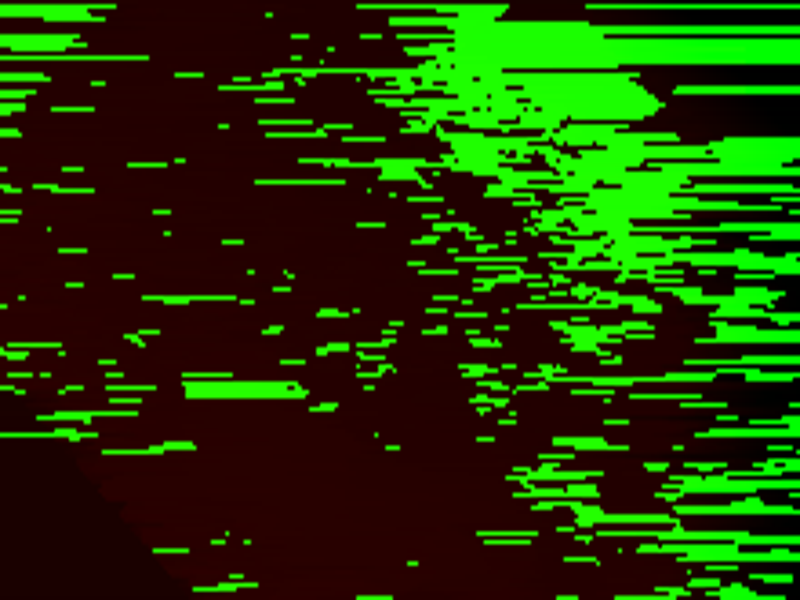

In [17]:
Image.fromarray(img_shift2.astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Norm maps (normed at 255)

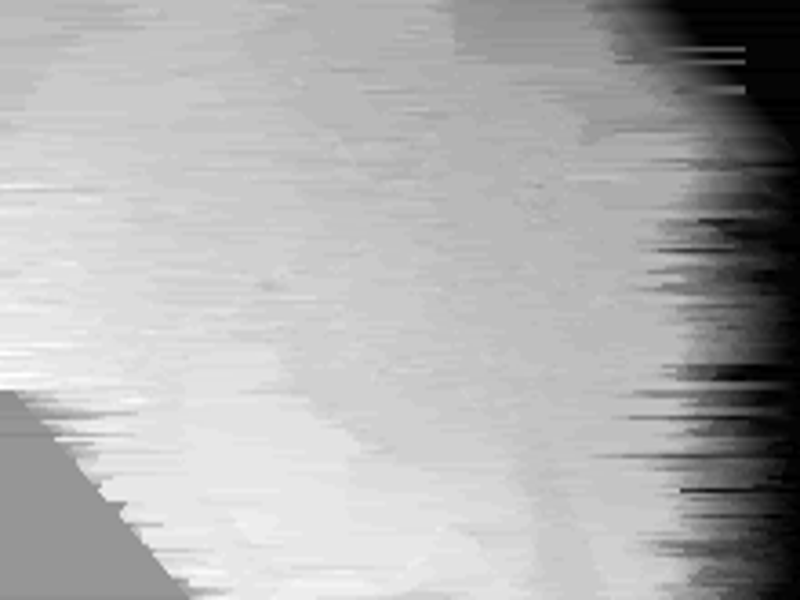

In [18]:
Image.fromarray(img_shift3.astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Original image

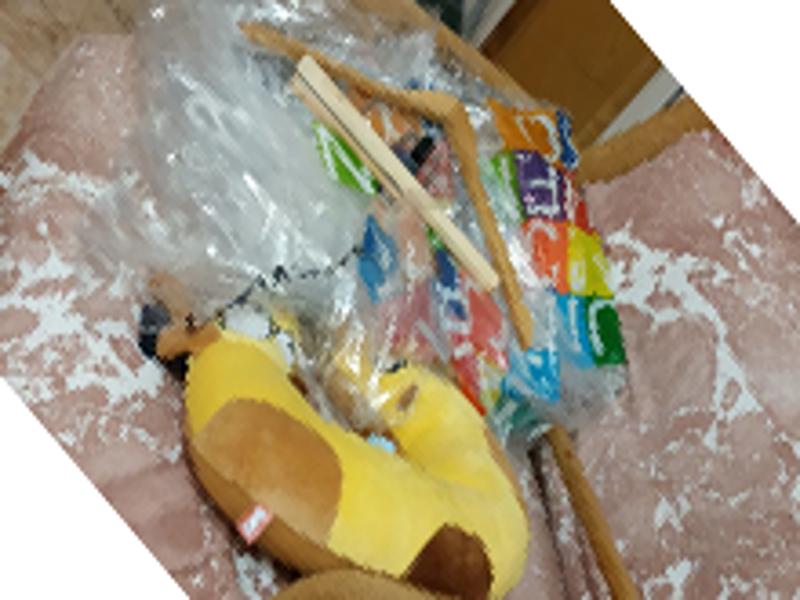

In [22]:
Image.fromarray(img_r.astype(np.uint8)).resize((800,600))

In [21]:
import matplotlib.pyplot as plt

(array([12240.,     0.,     0., 11799.,     0.,     0., 12117.,     0.,
            0., 21444.]),
 array([-2. , -1.7, -1.4, -1.1, -0.8, -0.5, -0.2,  0.1,  0.4,  0.7,  1. ]),
 <a list of 10 Patch objects>)

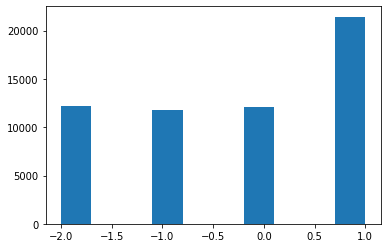

In [74]:
plt.hist(img_shift2[:,:,1].reshape(-1))